# **API Development Notebook**
This notebook documents the development and testing of the ts-media-bridge package, showing the development of API clients for Spotify and NYT, and data merging.

In [40]:
# Importing libraries 

import os
import base64
import requests
from dotenv import load_dotenv
import pandas as pd
import time
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

## 1. Spotify API Development 

Testing Spotify API authentication and basic functionality.

In [1]:
# Loading spotify client ID and secret key from .env

load_dotenv()

client_id = os.getenv("SPOTIFY_CLIENT_ID")
client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")

print("Client ID loaded:", client_id is not None)
print("Client Secret loaded:", client_secret is not None)

Client ID loaded: True
Client Secret loaded: True


### Spotify Authentication

Obtaining a Spotify access token using Client Credentials OAuth flow. 

In [2]:
def get_spotify_token(client_id: str, client_secret: str) -> str:
    auth_string = f"{client_id}:{client_secret}"
    auth_bytes = auth_string.encode("utf-8")
    auth_b64 = base64.b64encode(auth_bytes).decode("utf-8")

    headers = {
        "Authorization": f"Basic {auth_b64}",
        "Content-Type": "application/x-www-form-urlencoded",}

    data = {"grant_type": "client_credentials"}

    r = requests.post(
        "https://accounts.spotify.com/api/token",
        headers=headers,
        data=data,
        timeout=15)
    r.raise_for_status()

    return r.json()["access_token"]

In [8]:
# Checking and showing first 20 chars

token = get_spotify_token(client_id, client_secret)
token[:10]

'BQCj2E97YG'

### Testing Artist Endpoint

Testing with Taylor Swift's artist ID.

In [5]:
def get_artist(artist_id: str, token: str):
    headers = {"Authorization": f"Bearer {token}"}
    url = f"https://api.spotify.com/v1/artists/{artist_id}"
    r = requests.get(url, headers=headers, timeout=15)
    r.raise_for_status()
    return r.json()

TS_ID = "06HL4z0CvFAxyc27GXpf02"  # Taylor Swift
artist_data = get_artist(TS_ID, token)

print(f"Artist: {artist_data['name']}")
print(f"Followers: {artist_data['followers']['total']:,}")
print(f"Popularity: {artist_data['popularity']}")

Artist: Taylor Swift
Followers: 147,763,029
Popularity: 100


## 2. NYT API Development

Testing NYT Article Search API functionality.

In [11]:
load_dotenv()

nyt_api_key = os.getenv("NYT_API_KEY")
client_secret = os.getenv("NYT_CLIENT_SECRET")

def mask(s):
    if not s:
        return None
    return s[:4] + "..." + s[-4:]

print("NYT_API_KEY loaded:", nyt_api_key is not None)
print("NYT Client Secret loaded:", client_secret is not None)

NYT_API_KEY loaded: True
NYT Client Secret loaded: True


### Basic Article Search

Testing search for Taylor Swift articles.

In [12]:
NYT_BASE_URL = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

def search_nyt_taylor_swift(api_key: str, page: int = 0):
    params = {
        "q": "Taylor Swift",
        "api-key": api_key,
        "page": page,}
    r = requests.get(NYT_BASE_URL, params=params, timeout=15)
    r.raise_for_status()
    return r.json()

In [13]:
nyt_data = search_nyt_taylor_swift(nyt_api_key, page=0)
print("Response type:", type(nyt_data))
print("Keys:", nyt_data.keys())

Response type: <class 'dict'>
Keys: dict_keys(['status', 'copyright', 'response'])


In [16]:
# Showing first TS article 

first = docs[0]
print(f"Headline: {first['headline']['main']}")
print(f"Date: {first['pub_date']}")
print(f"Section: {first.get('section_name', 'N/A')}")

Headline: Anticipating Taylor Swift’s ‘The Life of a Showgirl’
Date: 2025-08-18T09:03:25Z
Section: Arts


### Sample Articles on Taylor Swift 

In [17]:
# Extracting recent Taylor Swift-related articles 

print("Recent Taylor Swift articles:\n")
for i, d in enumerate(docs[:5], 1):
    print(f"{i}. {d['pub_date'][:10]} – {d['headline']['main']}")

Recent Taylor Swift articles:

1. 2025-08-18 – Anticipating Taylor Swift’s ‘The Life of a Showgirl’
2. 2025-10-04 – Breaking Down Taylor Swift’s ‘The Life of a Showgirl’
3. 2025-08-12 – Taylor Swift Announces New Album, ‘The Life of a Showgirl’
4. 2025-09-11 – Stephanie Burt on Taylor Swift and Some Other Favorite Geniuses
5. 2025-10-04 – In Taylor’s Version, Ophelia Has a Fairy-Tale Ending


## 3. Testing the ts-media-bridge Package

Testing the implementation of the package.

### Testing SpotifyClient

In [21]:
from ts_media_bridge import SpotifyClient

sp = SpotifyClient()
ts = sp.get_artist("06HL4z0CvFAxyc27GXpf02")

print(f"Artist: {ts['name']}")
print(f"Followers: {ts['followers']['total']:,}")
print(f"Popularity: {ts['popularity']}")

Artist: Taylor Swift
Followers: 147,763,029
Popularity: 100


### Getting Taylor Swift's Albums

Using `get_artist_albums_df()` method to return a clean data frame with metadata.

In [22]:
df_albums = sp.get_artist_albums_df("06HL4z0CvFAxyc27GXpf02")

print(f"Total albums: {len(df_albums)}")
print(f"\nColumns: {df_albums.columns.tolist()}")
print(f"\nSample albums:")
print(df_albums[['name', 'release_date', 'popularity', 'is_rerecording']].head(10))

Total albums: 17

Columns: ['id', 'name', 'base_title', 'album_type', 'total_tracks', 'release_date', 'release_date_precision', 'popularity', 'label', 'genres', 'is_rerecording', 'is_deluxe', 'artists', 'external_urls.spotify']

Sample albums:
                             name release_date  popularity  is_rerecording
1          The Life of a Showgirl   2025-10-03         100           False
4   THE TORTURED POETS DEPARTMENT   2024-04-18          82           False
6         1989 (Taylor's Version)   2023-10-26          82            True
7    Speak Now (Taylor's Version)   2023-07-07          80            True
10                      Midnights   2022-10-21          82           False
11         Red (Taylor's Version)   2021-11-12          84            True
12    Fearless (Taylor's Version)   2021-04-09          81            True
13      evermore (deluxe version)   2021-01-07          77           False
14                       evermore   2020-12-11          77           False
16    

### Testing NYTClient

In [23]:
from ts_media_bridge import NYTClient

nyt = NYTClient()

# Searching for Taylor Swift articles
articles = nyt.search_taylor_swift(pages=3)
print(f"Retrieved {len(articles)} articles")

# Converting to DataFrame
df_articles = nyt.docs_to_df(articles)
print(f"\nDataFrame shape: {df_articles.shape}")
print(f"Columns: {df_articles.columns.tolist()}")

[NYT] Rate limiting: waiting 6.1s before next request...
[NYT] Rate limiting: waiting 5.9s before next request...
Retrieved 30 articles

DataFrame shape: (30, 8)
Columns: ['pub_date', 'headline', 'snippet', 'section', 'source', 'news_desk', 'type_of_material', 'web_url']


## 4. Data Collection & Analysis

Combining Spotify and NYT data to analyze the relation between streaming popularity and media coverage.

### Data Collection & Matching Articles to Albums

* Data collection strategy: Avoid rate limits by spacing out requests.
* Using text matching to connect NYT articles with specific albums.

In [44]:
from ts_media_bridge import SpotifyClient, NYTClient, match_articles_to_albums

sp = SpotifyClient()
nyt = NYTClient()
TS_ID = "06HL4z0CvFAxyc27GXpf02"

# Getting albums
df_albums = sp.get_artist_albums_df(TS_ID)
print(f"Found {len(df_albums)} albums\n")

# Step 2: Collecting articles strategically
## Making fewer, targeted requests
print("Collecting NYT articles")
print("=" * 60)

all_docs = []

# Strategy A: Getting recent articles (most relevant)
print("\n1. Fetching recent articles (2023-present)...")
recent_docs = nyt.search_taylor_swift(pages=5, begin_date="20230101")
all_docs.extend(recent_docs)
print(f"   Found {len(recent_docs)} recent articles")
time.sleep(2)  # safety pause

# Strategy B: Getting folklore/evermore era (2020-2021)
print("\n2. Fetching folklore/evermore era (2020-2021)...")
folklore_docs = nyt.search_taylor_swift(pages=3, begin_date="20200101", end_date="20211231")
all_docs.extend(folklore_docs)
print(f"   Found {len(folklore_docs)} articles from 2020-2021")
time.sleep(2)

# Strategy C: Getting 1989/reputation era (2014-2018)
print("\n3. Fetching 1989/reputation era (2014-2018)...")
rep_docs = nyt.search_taylor_swift(pages=3, begin_date="20140101", end_date="20181231")
all_docs.extend(rep_docs)
print(f"   Found {len(rep_docs)} articles from 2014-2018")
time.sleep(2)

# Strategy D: Getting early career (2008-2013)
print("\n4. Fetching early career (2008-2013)...")
early_docs = nyt.search_taylor_swift(pages=2, begin_date="20080101", end_date="20131231")
all_docs.extend(early_docs)
print(f"   Found {len(early_docs)} articles from 2008-2013")

# Converting to df
df_articles = nyt.docs_to_df(all_docs)
df_articles = df_articles.drop_duplicates(subset=['web_url'])
print(f"\nTotal unique articles: {len(df_articles)}")

# Step 3: Matching to albums
print("\nMatching articles to albums...")
df_matched = match_articles_to_albums(df_albums, df_articles)
print(f"Matched {len(df_matched)} article-album pairs\n")

# Step 4: Analyzing results
mentions = (
    df_matched.groupby("album_base_title")["web_url"]
    .nunique()
    .reset_index(name="nyt_article_count")
    .sort_values("nyt_article_count", ascending=False))

print("=" * 60)
print("NYT Article Mentions by Album:")
print("=" * 60)
print(mentions.to_string(index=False))

# Step 5: Merging with Spotify data
df_albums_basic = df_albums[['base_title', 'release_date', 'popularity', 
                              'is_rerecording']].drop_duplicates(subset=['base_title'])

df_analysis = df_albums_basic.merge(
    mentions,
    left_on='base_title',
    right_on='album_base_title',
    how='left')
df_analysis['nyt_article_count'] = df_analysis['nyt_article_count'].fillna(0).astype(int)

print("\n" + "=" * 60)
print("Albums with Spotify Popularity vs NYT Coverage:")
print("=" * 60)
print(df_analysis[['base_title', 'release_date', 'popularity', 
                   'nyt_article_count']].to_string(index=False))

# Step 6: Displaying some matches
print("\n" + "=" * 60)
print("Sample Article-Album Matches:")
print("=" * 60)
for album in df_matched['album_base_title'].unique()[:5]:
    album_matches = df_matched[df_matched['album_base_title'] == album]
    print(f"\n{album} ({len(album_matches)} mentions):")
    for _, match in album_matches.head(2).iterrows():
        print(f"  • {match['headline'][:80]}...")
        print(f"    Published: {match['pub_date'][:10]}")

# Step 7: Saving results
print("\n" + "=" * 60)
df_matched.to_csv('album_article_matches.csv', index=False)
df_analysis.to_csv('album_analysis.csv', index=False)
df_articles.to_csv('nyt_articles.csv', index=False)
print("Saved:")
print("album_article_matches.csv")
print("album_analysis.csv")
print("nyt_articles.csv")

Found 18 albums


1. Fetching recent articles (2023-present)...
[NYT] Rate limiting: waiting 6.0s before next request...
[NYT] Rate limiting: waiting 6.1s before next request...
[NYT] Rate limiting: waiting 6.1s before next request...
[NYT] Rate limiting: waiting 6.0s before next request...
   Found 50 recent articles

2. Fetching folklore/evermore era (2020-2021)...
[NYT] Rate limiting: waiting 4.0s before next request...
[NYT] Rate limit hit (429) despite precautions! Waiting 8s before retry 1/3...
[NYT] Rate limit hit (429) despite precautions! Waiting 16s before retry 2/3...
[NYT] Rate limiting: waiting 6.0s before next request...
[NYT] Rate limiting: waiting 6.1s before next request...
   Found 30 articles from 2020-2021

3. Fetching 1989/reputation era (2014-2018)...
[NYT] Rate limiting: waiting 4.0s before next request...
[NYT] Rate limiting: waiting 6.0s before next request...
[NYT] Rate limiting: waiting 6.0s before next request...
[NYT] Rate limit hit (429) despite precaution

### Creating Combined Dataset

Merging Spotify metadata with NYT article counts.

In [45]:
# Loading saved files 
df_saved_analysis = pd.read_csv('album_analysis.csv')
df_saved_matches = pd.read_csv('album_article_matches.csv')

print("Saved Analysis File:")
print(df_saved_analysis.head())
print(f"\nShape: {df_saved_analysis.shape}")
print(f"Columns: {df_saved_analysis.columns.tolist()}")

print("\nSaved Matches File:")
print(df_saved_matches.head())
print(f"\nShape: {df_saved_matches.shape}")
print(f"Columns: {df_saved_matches.columns.tolist()}")

# Creating a combined dataset including ALL Spotify metadata + NYT coverage
df_final = df_albums[['id', 'name', 'base_title', 'album_type', 'total_tracks', 
                      'release_date', 'popularity', 'label', 'is_rerecording', 
                      'is_deluxe']].drop_duplicates(subset=['base_title'])

# Adding NYT article counts
mentions = (
    df_matched.groupby("album_base_title")["web_url"]
    .nunique()
    .reset_index(name="nyt_article_count"))

# Fixing combined dataset 
df_final = df_albums[['id', 'name', 'base_title', 'album_type', 'total_tracks', 
                      'release_date', 'popularity', 'label', 'is_rerecording', 
                      'is_deluxe']].drop_duplicates(subset=['base_title'])

df_final = df_final.merge(
    mentions,
    left_on='base_title',
    right_on='album_base_title',
    how='left')

# Dropping redundant column and filling NaNs
df_final = df_final.drop(columns=['album_base_title'])  
df_final['nyt_article_count'] = df_final['nyt_article_count'].fillna(0).astype(int)

# Adding year for analysis
df_final['release_year'] = pd.to_datetime(df_final['release_date']).dt.year

# Sorting by release date
df_final = df_final.sort_values('release_date').reset_index(drop=True)

print("--CLEANED FINAL COMBINED DATASET--")
print(df_final)

# Saving cleaned version
df_final.to_csv('taylor_swift_combined_analysis.csv', index=False)
print("\n Saved cleaned version to: taylor_swift_combined_analysis.csv")

Saved Analysis File:
                      base_title release_date  popularity  is_rerecording  \
0         The Life of a Showgirl   2025-10-03         100           False   
1  THE TORTURED POETS DEPARTMENT   2024-04-18          82           False   
2                           1989   2023-10-26          82            True   
3                      Speak Now   2023-07-07          80            True   
4                      Midnights   2022-10-21          82           False   

         album_base_title  nyt_article_count  
0  The Life of a Showgirl                 12  
1                     NaN                  0  
2                    1989                  1  
3                     NaN                  0  
4                     NaN                  0  

Shape: (12, 6)
Columns: ['base_title', 'release_date', 'popularity', 'is_rerecording', 'album_base_title', 'nyt_article_count']

Saved Matches File:
                 album_id              album_name        album_base_title  \
0  4a6N

### Summary Data

In [46]:
# Summary

print(f"Total albums: {len(df_final)}")
print(f"Albums with NYT coverage: {(df_final['nyt_article_count'] > 0).sum()}")
print(f"Total NYT articles matched: {df_final['nyt_article_count'].sum()}")
print(f"\nAlbums by NYT coverage:")
print(df_final[['base_title', 'release_year', 'popularity', 'nyt_article_count']].to_string(index=False))

Total albums: 12
Albums with NYT coverage: 7
Total NYT articles matched: 41

Albums by NYT coverage:
                   base_title  release_year  popularity  nyt_article_count
                 Taylor Swift          2006          67                  0
                   reputation          2017          87                 10
                        Lover          2019          88                  0
                     folklore          2020          75                  6
                     evermore          2021          77                  3
                     Fearless          2021          81                  4
                          Red          2021          84                  5
                    Midnights          2022          82                  0
                    Speak Now          2023          80                  0
                         1989          2023          82                  1
THE TORTURED POETS DEPARTMENT          2024          82                  0

### Creating Clean Albums Dataset

A canonical reference dataset of Taylor Swift albums.

In [48]:
ts_albums = df_final[[
    'id', 'name', 'base_title', 'release_date', 'release_year',
    'album_type', 'total_tracks', 'popularity', 'label',
    'is_rerecording', 'is_deluxe', 'nyt_article_count'
]].copy()

print("Taylor Swift Canonical Albums Dataset: ")
print(ts_albums)

# Saving
ts_albums.to_csv('ts_albums.csv', index=False)
print("Saved: ts_albums.csv")

Taylor Swift Canonical Albums Dataset: 
                        id                           name  \
0   7mzrIsaAjnXihW3InKjlC3                   Taylor Swift   
1   6DEjYFkNZh67HP7R9PSZvv                     reputation   
2   1NAmidJlEaVgA3MpcPFYGq                          Lover   
3   1pzvBxYgT6OVwJLtHkrdQK      folklore (deluxe version)   
4   6AORtDjduMM3bupSWzbTSG      evermore (deluxe version)   
5   4hDok0OAJd57SGIT8xuWJH    Fearless (Taylor's Version)   
6   6kZ42qRrzov54LcAk4onW9         Red (Taylor's Version)   
7   151w1FgRZfnKZA9FEcg9Z3                      Midnights   
8   5AEDGbliTTfjOB8TSm1sxt   Speak Now (Taylor's Version)   
9   64LU4c1nfjz1t4VnGhagcg        1989 (Taylor's Version)   
10  1Mo4aZ8pdj6L1jx8zSwJnt  THE TORTURED POETS DEPARTMENT   
11  4a6NzYL1YHRUgx9e3YZI6I         The Life of a Showgirl   

                       base_title release_date  release_year album_type  \
0                    Taylor Swift   2006-10-24          2006      album   
1               

### Visualizing the Results

Explore the relationship between Spotify popularity and NYT coverage.

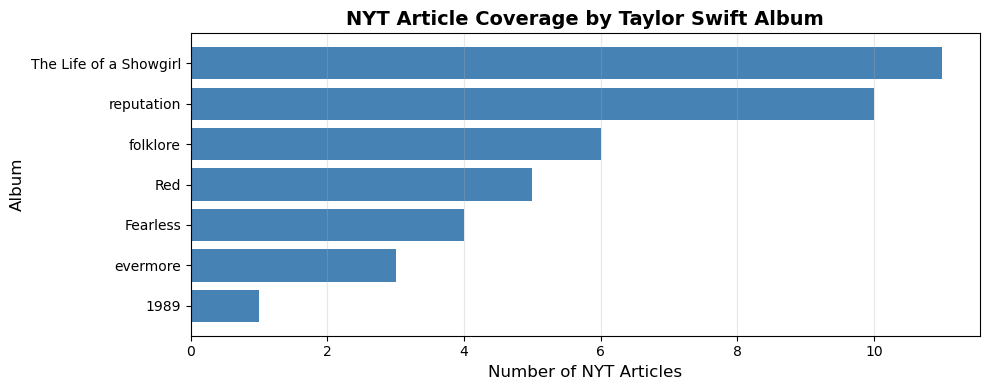

In [42]:
# Visualization 1: NYT Coverage by Album

fig, ax = plt.subplots(figsize=(10, 4))

albums_with_coverage = df_final[df_final['nyt_article_count'] > 0].sort_values('nyt_article_count', ascending=True)

ax.barh(albums_with_coverage['base_title'], albums_with_coverage['nyt_article_count'], color='steelblue')
ax.set_xlabel('Number of NYT Articles', fontsize=12)
ax.set_ylabel('Album', fontsize=12)
ax.set_title('NYT Article Coverage by Taylor Swift Album', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('nyt_coverage_by_album.png', dpi=300, bbox_inches='tight')
plt.show()

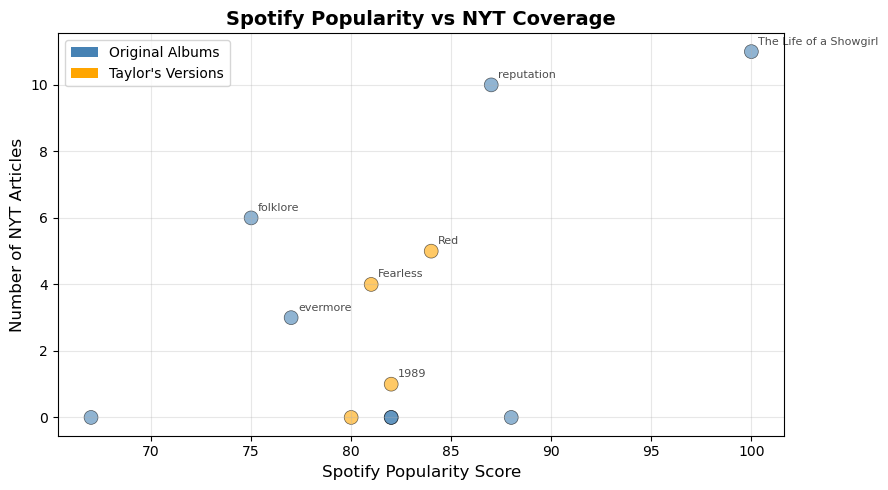

In [43]:
# Visualization 2: Spotify Popularity vs NYT Coverage

fig, ax = plt.subplots(figsize=(9, 5))

# Scatter plot
scatter = ax.scatter(
    df_final['popularity'], 
    df_final['nyt_article_count'],
    s=100,
    alpha=0.6,
    c=df_final['is_rerecording'].map({True: 'orange', False: 'steelblue'}),
    edgecolors='black',
    linewidth=0.5)

# Adding labels for albums with coverage
for _, row in df_final[df_final['nyt_article_count'] > 0].iterrows():
    ax.annotate(
        row['base_title'],
        (row['popularity'], row['nyt_article_count']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        alpha=0.7)

ax.set_xlabel('Spotify Popularity Score', fontsize=12)
ax.set_ylabel('Number of NYT Articles', fontsize=12)
ax.set_title('Spotify Popularity vs NYT Coverage', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Adding legend
legend_elements = [
    Patch(facecolor='steelblue', label='Original Albums'),
    Patch(facecolor='orange', label="Taylor's Versions")]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.savefig('spotify_vs_nyt_coverage.png', dpi=300, bbox_inches='tight')
plt.show()